### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="http://github.com/Nak007/anomaly"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')

# Import other libraries required.
# All *.py will be stored under the following 
# location i.e. '/content/anomaly'.
!git clone 'http://github.com/Nak007/anomaly.git'

# Change current directory to where *.py is stored.
%cd '/content/anomaly'

In [1]:
# Import libraries.
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
pd.options.display.float_format = '{:,.3f}'.format

from Outlier import outliers
from PlotRelated import *
from pca_analysis import pca
from Cutoffs import optimize_condition
from TwoSampleTest import ks_test

## Examples

In [2]:
from sklearn.datasets import load_breast_cancer as data
X, y = data(return_X_y=True)
X = pd.DataFrame(X, columns=[s.replace(' ','_') for s in data().feature_names])

In this example, we are dealing with high dimensional data, using `Principal Component Analysis` (`PCA`) helps reducing number of variables (dimensionality reduction) by performing a linear mapping (`eigenvector`) to a lower-dimensional space.

### <font size=4.5>( 1 ) Determine number of `Principal Components`.</font>

Output :
- pc_df : `pd.DataFrame` object of principal components.
- loadings : `pd.DataFrame` object of `eigenvector`.
- var : list of variables that pass `vec_cutoff`.

In [3]:
pc_df, loadings, _, var = pca(X, vec_cutoff=0.3)

In [4]:
pc_df.sample(5)

,PC01,PC02,PC03,PC04,PC05,PC06
493,0.085,-0.097,1.318,0.487,-0.557,-0.225
125,0.911,-0.410,-0.776,0.175,-0.440,0.103
466,0.375,-0.093,-0.504,-0.198,0.526,-0.173
236,-1.568,1.165,-1.947,-0.588,0.299,-2.400
218,-0.668,1.123,-0.676,0.255,0.107,-1.743


### <font size=4.5>( 2 ) Anomaly detection.</font>

### Isolation Forest
- For this example, `IsolationForest` from `sklearn.ensemble` is selected.
- Prediction array is comprised of `0` for `normal`, `1` for `anomaly`.

---
The `IsolationForest` isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. 
Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of such random trees, is a measure of normality.

- The anomaly score $s$ of an instance $x$ is defined as:
    - $s(x,n) = 2^{-\frac{E(h(x)}{c(n)}}$
    
    
- Path Length $h(x)$ of a point $x$ is measured by the number of edges $x$ traverses an iTree from the root node.
- $c(n)$ is the average path length of iTree or the average of $h(x)$ given $n$, which can be expressed as:
    - $c(n)$ = $2H(n − 1) − \frac{2(n − 1)}{n}$
    - $H(i)$ is the harmonic number and it can be estimated by $H(i) ≈\log(i) + 0.5772156649$ (Euler’s constant).
    - $H_{n}=1+{\frac{1}{2}}+{\frac {1}{3}}+\cdots +{\frac {1}{n}}=\sum _{k=1}^{n}{\frac {1}{k}}$
    - $n$ is the number of samples.


$E(h(x))$ is the average of $h(x)$ from a collection of isolation trees. The relationship between $E(h(x))$ and $s$ can be summarized as follow:
- when $E(h(x))$ $\Longrightarrow$ $c(n)$, $s$ $\Longrightarrow$ 0.5
- when $E(h(x))$ $\Longrightarrow$ 0, $s$ $\Longrightarrow$ 1;
- when $E(h(x))$ $\Longrightarrow$ $n$−1, $s$ $\Longrightarrow$ 0.

Using the anomaly score $s$, we are able to make the following assessment:

- (a) if instances return $s$ very close to 1, then they are definitely anomalies,
- (b) if instances have $s$ much smaller than 0.5, then they are quite safe to be regarded as normal instances, and
- (c) if all the instances return $s$ ≈ 0.5, then the entire sample does not really have any distinct anomaly.

---
It is noteworthy that anomaly scores from `sklearn.ensemble.IsolationForest` does not follow the same calculation as stated in original paper.

- $s(x,n)_{sklearn}$ or `self.score_samples` = $-s(x,n)_{original}$
- `self.decision_function` = `self.score_samples` - `self.offset_`, where `self.offset` = -0.5
- If `self.decision_function` is less than 0 for any given `x`, such `x` is categorized as anomaly. This also depends on `self.offset_`.
- $E(h(x)) = \frac{1}{T}\sum_{i=1}^{T} \left(\sum_{j=1}^{{N}_{i}} (1|e_{j}\in e_{i,x}) + c(n(i,x))\right)$, where
    - $T$ is the number of estimators,
    - $N_{i}$ is the number of nodes in tree $i$, 
    - $e_{i,x}$ is the nodes in $i$ that $x$ passes,
    - $c(n)$ = $2H(n − 1) − \frac{2(n − 1)}{n}$, and
    - $n(i,x)$ is the number of samples in $i$ at external node, where $x$ stops.
- average path length = $c($self.max_samples_$)$.
- max_depth = $int(\lceil\log_{2}(max($ self.max_samples $, 2))\rceil)$.
- use `sklearn.ensemble.ExtraTreeRegressor` as a base estimator.
- y = np.random.uniform(size=X.shape[0])

---
Reference : 
- [Isolation Forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)
- [scikit-learn-isolationforest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) 
- [scikit-learn-isolationforest-anomaly-score](https://stats.stackexchange.com/questions/335274/scikit-learn-isolationforest-anomaly-score)

In [5]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(n_estimators=200, max_samples=50, max_features=4, 
                     random_state=0, behaviour='new', contamination='auto')
y_if = np.where(IF.fit_predict(pc_df)==-1,1,0)

In [6]:
def plot_score(score, y, cutoff, title, bins=30):
    
    hist, bins = np.histogram(score, bins=bins)
    c = lambda y,n : (y==n).sum()
    p = lambda y,n : c(y,n)/len(y)
    s = lambda y,n : ' ({:,.4g}, {:.2%})'.format(c(y,n),p(y,n))
    plt.hist(score[y==0], bins=bins, color='#10ac84', label='normal' + s(y,0))
    plt.hist(score[y==1], bins=bins, color='#ee5253', label='anomaly' + s(y,1))
    plt.title(title, fontsize=12)
    label = r'cutoff$_{LOF}$ '+'({:,.4g})'.format(cutoff)
    plt.axvline(cutoff, lw=1, ls='--', color='k', label=label)
    plt.legend(loc='best', framealpha=0, fontsize=10)
    plt.show()

Let's see where `IsolationForest` defines `cutoff` for `anomaly` (`contamination`='auto').

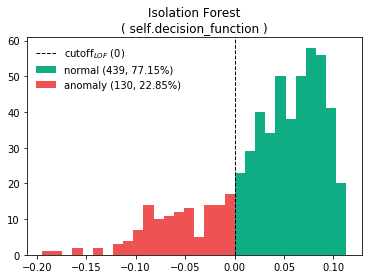

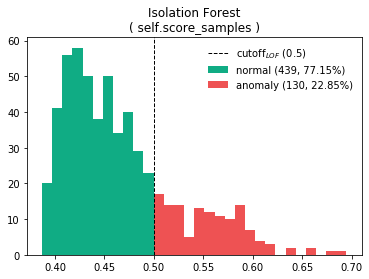

In [7]:
plot_score(IF.decision_function(pc_df), y_if, 0, 'Isolation Forest\n( self.decision_function )')
plot_score(-IF.score_samples(pc_df), y_if, 0.5, 'Isolation Forest\n( self.score_samples )')

Let's see how cuttoff works when `self.offset_` is changed to **-0.6**.

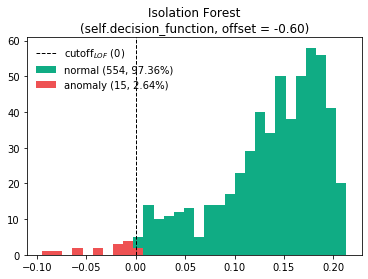

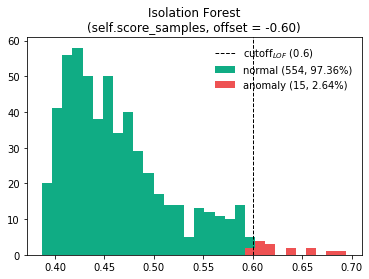

In [8]:
IF.fit(pc_df)
IF.offset_ = -0.6
y_if = np.where(IF.predict(pc_df)==-1,1,0)

plot_score(IF.decision_function(pc_df), y_if, 0, 
           'Isolation Forest\n(self.decision_function, offset = %0.2f)' % IF.offset_)
plot_score(-IF.score_samples(pc_df), y_if, -IF.offset_, 
           'Isolation Forest\n(self.score_samples, offset = %0.2f)' % IF.offset_)

Alternatively, we can use `outlier` to determine `cutoff` (method = `gamma`).

In [9]:
model = outliers(method='gamma')
score = -IF.score_samples(pc_df)
model.fit(pd.DataFrame({'score': score}))

c = model.limit_['upper'][0]; n = (score>=c).sum()
s = 'Cutoff = {:.4f} ==> Number of anomalies = {:,.4g} ({:.0%})'
print(s.format(c, n, n/len(score)))

Cutoff = 0.6024 ==> Number of anomalies = 13 (2%)


### LocalOutlierFactor
Alternatively, we can use `LocalOutlierFactor` from `sklearn.neighbors`.

---
The [LocalOutlierFactor](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest) (LOF) algorithm computes a score (called local outlier factor) reflecting the degree of abnormality of the observations. It measures the local density deviation of a given data point with respect to its neighbors. The idea is to detect the samples that have a substantially lower density than their neighbors.

- $k^{th}$ neighbour of $x$
- `Averge Reachability distance` of $x$ $\Longrightarrow$ $ARD(x)$ = $\frac{1}{k}\sum_{i=1}^{k}max(d_{i,k},d_{i,x})$
    - $d_{i,k}$ is the $k^{th}$ nearest distance to $i$, 
    - $d_{i,x}$ is the distance between $i$ and $x$,
    - $k$ is the number of neighbour.
- `Local Reachability distance` of $x$ $\Longrightarrow$ $LRD(x)$ = $\frac{1}{ARD(x)}$
- `Local Outlier Factor` of $x$ $\Longrightarrow$ LOF($x$) = $\frac{\frac{1}{k}\sum_{i=1}^{k}LRD(i)}{LRD(x)}$

---
Reference : `scikit-learn.org`

In [10]:
from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor(n_neighbors=100, contamination='auto')
y_lof = np.where(LOF.fit_predict(pc_df)==-1,1,0)

Let's see where `LocalOutlierFactor` defines `cutoff` for `anomaly` (`contamination`='auto').

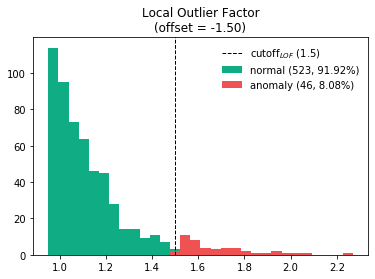

In [11]:
plot_score(-LOF.negative_outlier_factor_, y_lof, -LOF.offset_,
           'Local Outlier Factor\n(offset = %0.2f)' % LOF.offset_)

In [12]:
model = outliers(method='gamma')
lof_score = -LOF.negative_outlier_factor_
model.fit(pd.DataFrame({'score': lof_score}))

c = model.limit_['upper'][0]; n = (lof_score>=c).sum()
s = 'Cutoff = {:.4f} ==> Number of anomalies = {:,.4g} ({:.0%})'
print(s.format(c, n, n/len(lof_score)))

Cutoff = 1.5034 ==> Number of anomalies = 46 (8%)


### <font size=4.5>( 3 ) Result analysis.</font>

### <font color='#e84118' size=4> ** Decision required **</font>
- Select result of `anomaly` from available model predictions.
- Define `keyword argument` for plot.

In [13]:
anomaly = np.where(IF.fit_predict(pc_df)==-1,1,0)
plot_kwargs = dict(labels=['Normal','Anomaly'], colors=['#009432','#EA2027'])

- Pie chart represents proportion of 2 classes, which are `normal` and `anomaly`.
- The amount of `anomaly` is varied by which algorithm is used.

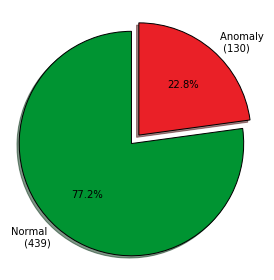

In [14]:
fig, ax = plt.subplots(figsize=(4,4))
params = dict(piedict={'shadow':True, 'startangle':90})
plot_pie(ax, anomaly, **{**plot_kwargs,**params})
fig.tight_layout()
plt.show()

- Visaulize `Principal Component` in pair and see how `feature` in `eigenvector` influence the spred or cluster of data.

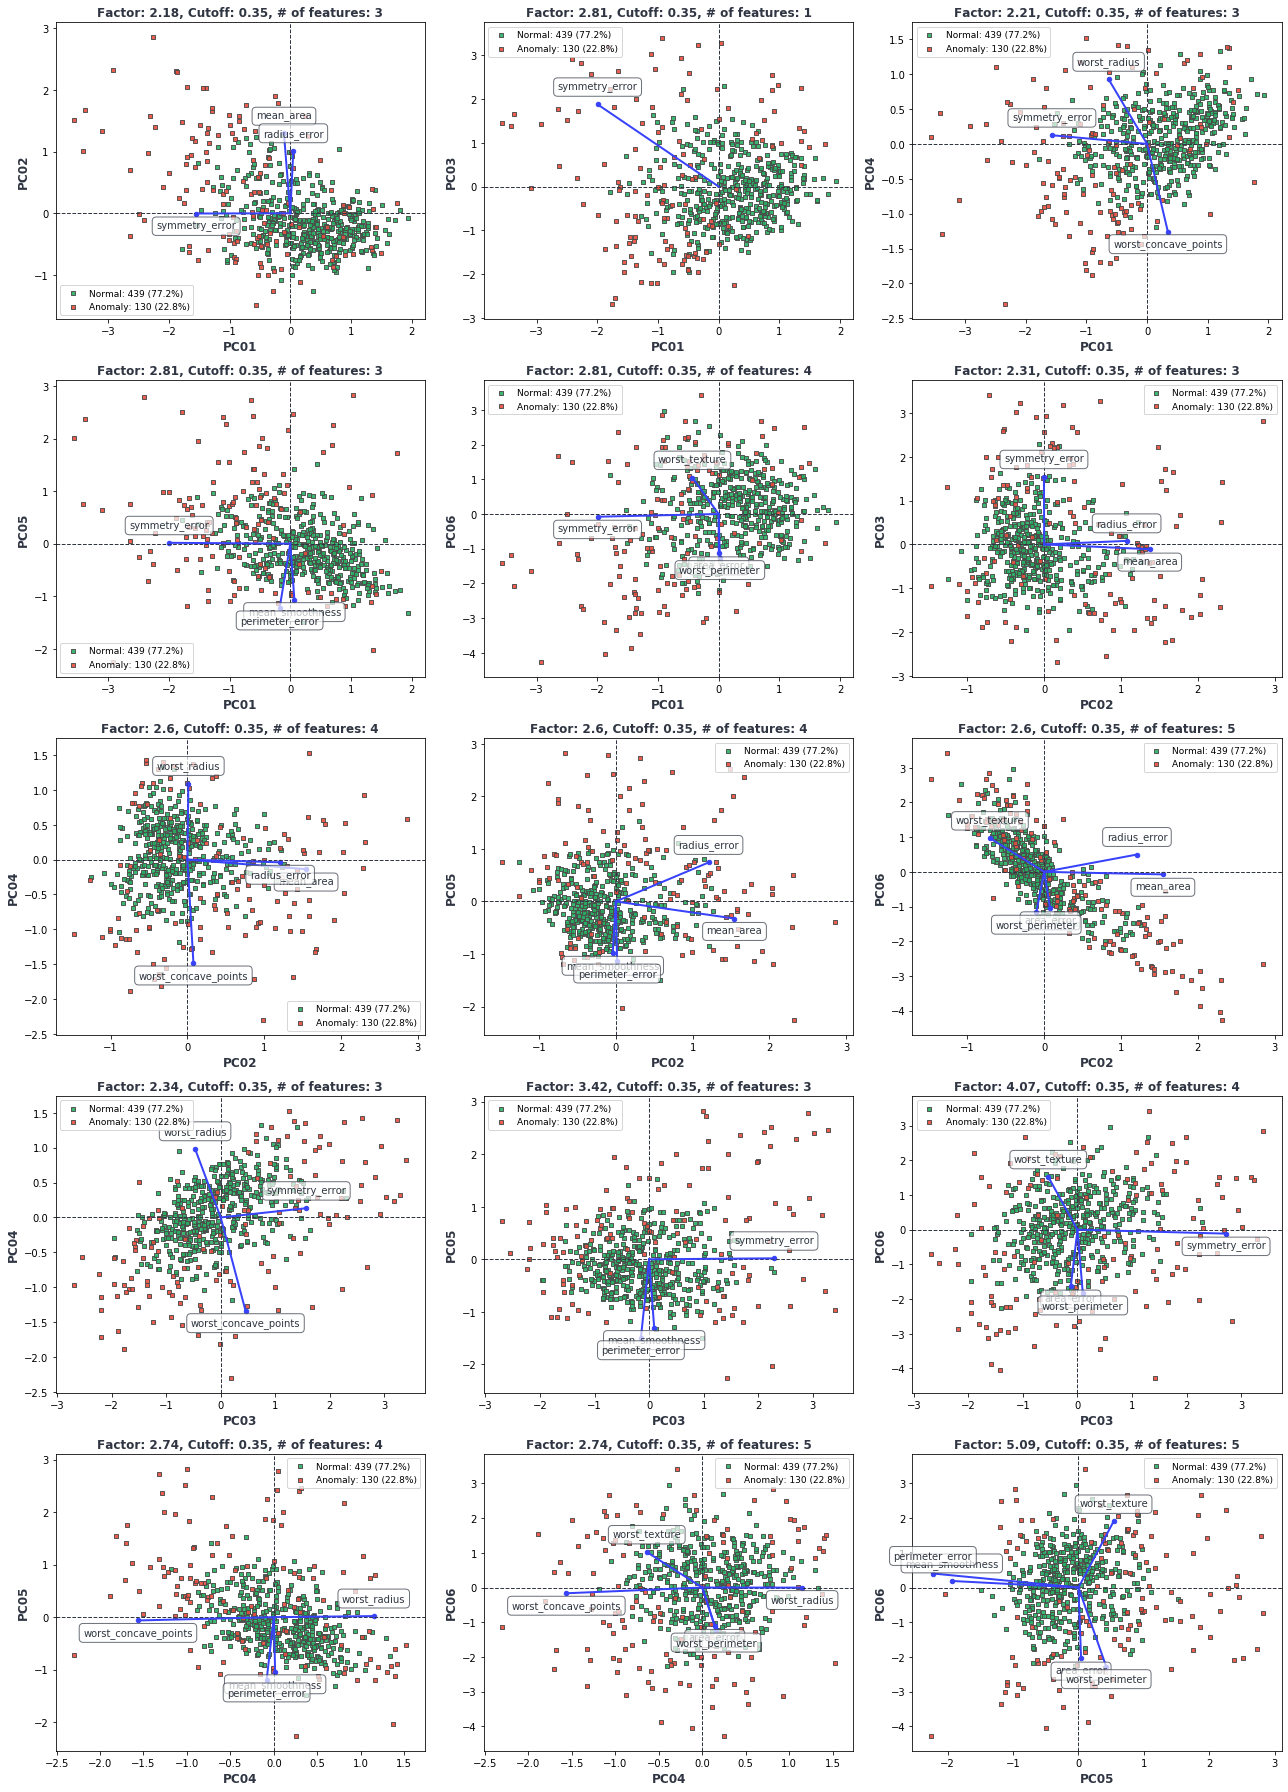

In [15]:
# Number of columns.
n_col = 3
cutoff = 0.35

# Combination of Principal Components.
pairs = list(combinations(np.arange(pc_df.shape[1])+1, 2))

# Number of rows --> Calculate from number of pairs and `n_col`
n_row = np.ceil(len(pairs)/n_col).astype(int)
n_pairs = len(pairs)

# Define `loc` (x,y) for each `plt.subplot`.
locs = [(r,c) for r in range(n_row) for c in range(n_col)][:n_pairs]

# Create figure and plots.
fig = plt.figure(figsize=(n_col*6, n_row*5))
axes = [plt.subplot2grid((n_row, n_col),loc) for loc in locs]
    
# Plot all combination of Principal Components.
for (ax,pc) in zip(axes, pairs):
    kw = dict(pc_pair=pc, cutoff=cutoff, colors=['#27ae60','#e74c3c'], 
              scatterdict={'alpha':0.9}, labels=['Normal','Anomaly'])
    plot_pcs(ax, anomaly, pc_df, loadings, **kw)
fig.tight_layout()
plt.show()

Although, using `Principal Component` might yield better result (due to scaling effect, `eigenvalue`), yet it is farily difficult when it comes to explanation. To avoid such confusion, we could try to use normal features instead.

---

- Find the difference of normalized values between `normal` and `anomaly` by features. This helps enable the comparison across features.
- `difference` can be viewed as a distance between two distributions from any nth-percentile of interests (`q`).
- point of comparison must be the same point across all methods e.g. 50th percentile.

In [16]:
# Normalize X.
n_min, n_max = np.nanpercentile(X, q=[0,100], axis=0)
norm_X = np.array((X-n_min)/np.where((n_max-n_min)==0,1,n_max-n_min))

In [17]:
# Find distance between two distributions.
def find_q_diff(X, y, q=50):
    def nan_pct(x,q): 
        return np.nanpercentile(x, q, axis=0).reshape(-1,1)
    v = np.hstack([nan_pct(X[y==c],q) for c in np.unique(y)])
    d = [(n,float(k)) for n,k in enumerate(np.diff(v,axis=1))]
    d.sort(reverse=True, key=lambda x: x[1])
    return np.array(d)

In [18]:
med_diff = find_q_diff(norm_X, anomaly)

In [19]:
med_cutoff = np.nanpercentile(med_diff[:,1], q=60) 
print('cutoff is estimated at {:,.4g}'.format(med_cutoff))

cutoff is estimated at 0.08378


- Visualize the `difference` and see how many features make the cutoff. 
- The `scree plot`, that is used to determine the number of factors e.g. `Principal Component`, is also applicable to determine number of features.

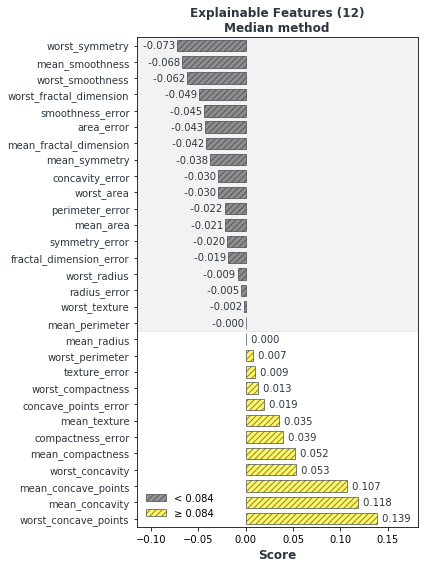

In [20]:
a,c = med_diff.copy(), med_cutoff.copy()

fig, ax = plt.subplots(figsize=(6,8))
features = np.array(list(X))[a[:,0].astype(int)]

# Assign values to `**params`.
ax.axhspan(11.5,100, alpha=0.1, color='grey')
params = dict(groups=np.where(a[:,1]>=c,1,0),
              colors=['#4b4b4b','#fff200'],
              labels=['< {:,.3f}'.format(c),
                      '≥ {:,.3f}'.format(c)],
              barhdict=dict(hatch='////', alpha=0.6),
              float_format=' {:,.3f}'.format)
plot_barh(ax, features, a[:,1]-c, **params)

# Set `title` and `xlabel`.
kwargs = dict(fontsize=12, color='#2f3542', fontweight='bold')
ax.set_xlabel('Score', **kwargs)
ax.set_title('Explainable Features ({:,.3g})\nMedian method'.
             format((a[:,1]>=c).sum()), **kwargs)
fig.tight_layout()
plt.show()

By using `percentile` method, there are 12 variables making the cut, which clearly illustrate the gap between two distributions, particularly the first three variables. However, we can use other methods to determine how far apart two distributions is. In this case, we introduce the so-called `Kolmogorov–Smirnov test` to measure aforementioned distance.

In [21]:
def find_ks_diff(X, y):
    d = [(n,ks_test(X[y==0,n],X[y==1,n])[0]) 
         for n in range(X.shape[1])]
    d.sort(reverse=True, key=lambda x: x[1])
    return np.array(d)

In [22]:
ks_diff = find_ks_diff(norm_X, anomaly)

In [23]:
ks_cutoff = np.nanpercentile(ks_diff[:,1], q=60) 
print('cutoff from `Kolmogorov–Smirnov test` is estimated at {:,.4g}'.format(ks_cutoff))

cutoff from `Kolmogorov–Smirnov test` is estimated at 0.317


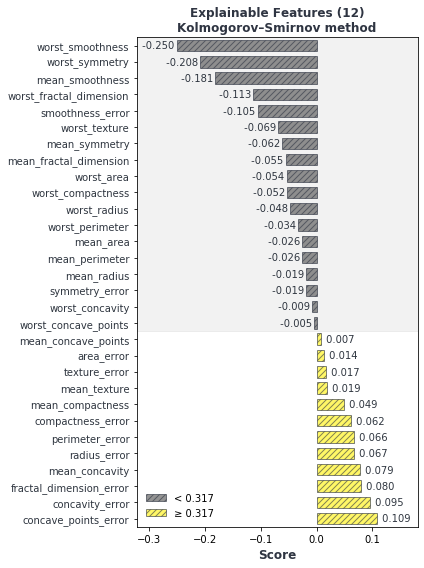

In [24]:
a,c = ks_diff.copy(), ks_cutoff.copy()

fig, ax = plt.subplots(figsize=(6,8))
features = np.array(list(X))[a[:,0].astype(int)]

# Assign values to `**params`.
ax.axhspan(11.5,100, alpha=0.1, color='grey')
params = dict(groups=np.where(a[:,1]>=c,1,0),
              colors=['#4b4b4b','#fff200'],
              labels=['< {:,.3f}'.format(c),
                      '≥ {:,.3f}'.format(c)],
              barhdict=dict(hatch='////', alpha=0.6),
              float_format=' {:,.3f}'.format)
plot_barh(ax, features, a[:,1]-c, **params)

# Set `title` and `xlabel`.
kwargs = dict(fontsize=12, color='#2f3542', fontweight='bold')
ax.set_xlabel('Score', **kwargs)
ax.set_title('Explainable Features ({:,.3g})\nKolmogorov–Smirnov method'.
             format((a[:,1]>=c).sum()), **kwargs)
fig.tight_layout()
plt.show()

### <font color='#e84118' size=4> ** Decision required ** </font>
- Select number of features (`variable`).

In [25]:
# Automatically select variable above cutoff.
variable = np.array(list(X))[med_diff[:,0].astype(int)][:12]

- Plot `variable` that make distinct difference (distance) between `normal` and `anomaly` distributions. 
- This provides an overview of how `normal` and `anomaly` differ from one another by prominent features.

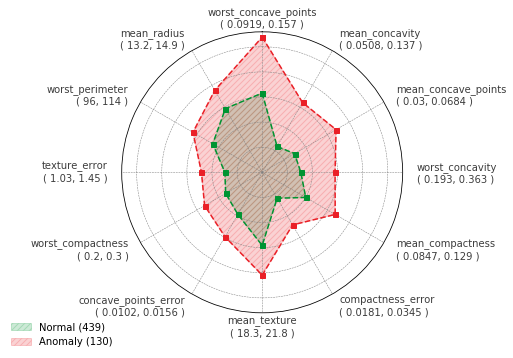

In [26]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(polar=True)
plotdict = dict(float_format='{:.3g}'.format,
                plotdict={'ls':'--','lw':1.5, 'ms':5, 'marker':'s'}, 
                filldict={'alpha':0.2, 'hatch':'////'})
plot_radar(ax, X[variable], anomaly, **{**plot_kwargs,**plotdict})
fig.tight_layout()
plt.show()

Alternatively, we can compute descriptive statistics (similarly to `pd.DataFrame.describe`) to observe e.g. the central tendency, dispersion and shape of distribution. This enables us to identify which `variable` that clearly separate `anomaly` from `normal`. 
    
For this example, we can create our own function to determine any statistical values of our interests. The applicable `aggregating function` inputs is either `numpy` based or other functions that implement the same interface.

In [27]:
# Function to use for aggregating the data.
def pct(n): 
    def nan_pct(x): return np.nanpercentile(x, n)
    nan_pct.__name__ = 'pct_{}'.format(n) 
    return nan_pct

def iqr():
    p = lambda x : np.nanpercentile(x, [25,75])
    def nan_iqr(x): return np.diff(p(x))
    nan_iqr.__name__ = 'iqr'
    return nan_iqr

In [28]:
stats = pd.concat((X[variable], pd.Series(anomaly, name='flag')),axis=1)

# Groupby aggregating functions.
n_flag = np.unique(anomaly).shape[0]
func = [pct(n) for n in range(0,101,25)]+ [iqr(), np.mean, np.std]
stats = stats.groupby('flag').agg(func).reset_index()

# Reconstruct `stats`.
stats = pd.concat([stats.loc[:,v].reset_index() for v in variable],axis=0)
stats = stats.reset_index(drop=True).rename({'index':'flag'},axis=1)
stats['feature'] = np.array([[v]*n_flag for v in variable]).ravel()
stats = stats.set_index(['feature','flag'])

In [29]:
stats.loc[stats.index.get_level_values('feature').isin(variable[:4])]

pct_0  pct_25  pct_50  pct_75  pct_100   iqr  mean  \
feature              flag                                                       
worst_concave_points 0     0.000   0.063   0.092   0.146    0.270 0.083 0.106   
                     1     0.000   0.078   0.157   0.210    0.291 0.133 0.144   
mean_concavity       0     0.000   0.027   0.051   0.101    0.319 0.074 0.072   
                     1     0.000   0.061   0.137   0.212    0.427 0.151 0.147   
mean_concave_points  0     0.000   0.019   0.030   0.060    0.156 0.041 0.042   
                     1     0.000   0.029   0.068   0.104    0.201 0.076 0.073   
worst_concavity      0     0.000   0.109   0.193   0.342    0.903 0.233 0.240   
                     1     0.000   0.168   0.363   0.578    1.252 0.410 0.382   

                            std  
feature              flag        
worst_concave_points 0    0.057  
                     1    0.082  
mean_concavity       0    0.060  
                     1    0.106  
mean_concave_points  0    0.031  
                     1    0.051  
worst_concavity      0    0.174  
                     1    0.270

Sometimes establishing a simple rule-based cutoff comes in handy as it provides an easy-to-understand limit, where data that lies beyond this point is identified as `anomaly`, as opposed to model that requires more effort to explain. 

In this example, `optimize_condition` is deployed to optimize the combination of `variable` that maximize `f1-score`. 

In [30]:
criteria = optimize_condition(X[variable].copy(), anomaly.copy(), n_max=1000)

In [31]:
criteria

{'criteria': [['concave_points_error', '≥', 0.01508],
  ['mean_texture', '≥', 25.44],
  ['worst_perimeter', '≥', 161.2],
  ['mean_concave_points', '≤', 0.003333],
  ['worst_concavity', '≥', 0.6956],
  ['mean_compactness', '≥', 0.2022]],
 'confusion_matrix': array([349,  14,  90, 116]),
 'f1_score': 0.6905}

### <font size=4.5>( 4 ) Interpretation.</font>
   
---    
- Data is identified as `anomaly` when it satisfies one of the following criteria in `cascading` manner, meaning that `Order` is complusory:

|Order|         Variable       |  Criteria | 
|:---:|:-----------------------|:---------:|
|  1  |**concave_points_error**|  ≥ 0.015  |
|  2  |**mean_texture**        |  ≥ 25.44  | 
|  3  |**worst_perimeter**     |  ≥ 161.2  |
|  4  |**mean_concave_points** |  ≤ 0.003  |
|  5  |**worst_concavity**     |  ≥ 0.696  | 
|  6  |**mean_compactness**    |  ≥ 0.202  |
    
- `confusion_matrix` is determined from `criteria` (returned dictionary from `optimize_condition`). Its elements are arranged in the following manner:

|Confusion Matrix  |  N | 
|:----------------:|---:|
|**True Negative** | 349|
|**False Negative**|  14| 
|**False Positive**|  90|
|**True Positive** | 116|